In [1]:
%matplotlib inline
import glob
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from skimage.feature import greycomatrix, greycoprops

Text(0.5, 1.0, 'ACA')

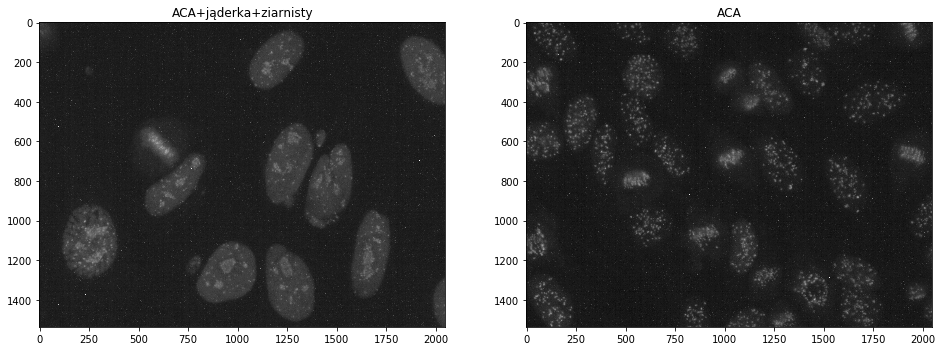

In [5]:
img1 = cv.imread('./data/sample/ACA+jąderka+ziarnisty(HEp2IIF)1.png')
img2 = cv.imread('./data/sample/ACA-1.png')
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

f, axes = plt.subplots(1, 2)
f.set_size_inches(16, 8)

axes[0].imshow(img1_gray, cmap='gray')
axes[0].set_title('ACA+jąderka+ziarnisty')

axes[1].imshow(img2_gray, cmap='gray')
axes[1].set_title('ACA')

In [9]:
def preprocess(img, size):
    img = img.copy()
    
    #resizing and denoising
    img = cv.resize(img, dsize=size, interpolation=cv.INTER_CUBIC)
    img = cv.fastNlMeansDenoising(img, h=5)
    
    # normalization
    min_ = np.amin(img)
    max_ = np.amax(img)
    norm = (img - min_) * (255 / (max_ - min_))
    return norm.astype(np.uint)

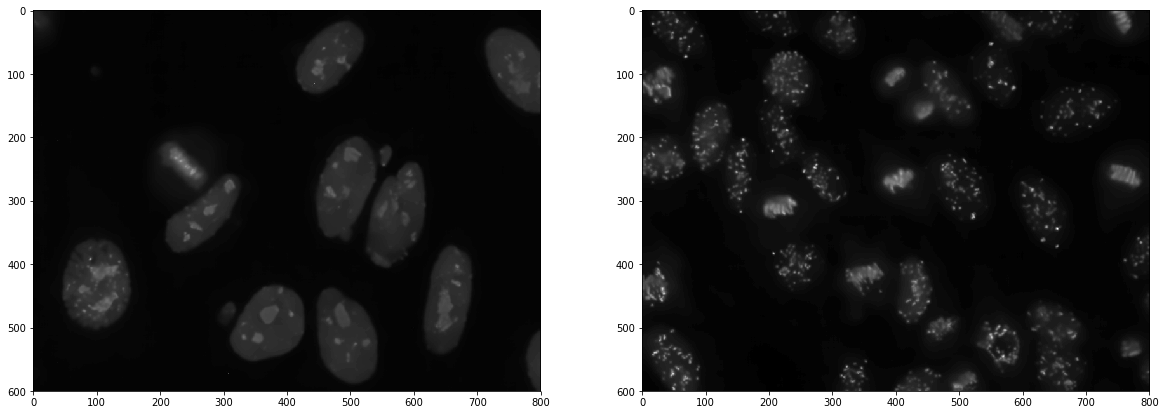

In [11]:
size = (800, 600)
norm1 = preprocess(img1_gray, size)
norm2 = preprocess(img2_gray, size)

f, a = plt.subplots(1, 2)
f.set_size_inches(20, 10)
a[0].imshow(norm1, cmap='gray')
a[1].imshow(norm2, cmap='gray')

# texture features extraction:

In [23]:
def texture_features(img, locs, rows, cols, stride):
    correlation = []
    dissimilarity = []
    
    for loc in locs:
        top, left = loc
        
        for r in range(rows):
            for c in range(cols):
                t = top + r * stride
                l = left + c * stride
                patch = img[t:t+stride, l:l+stride]

                glcm = greycomatrix(patch, [5], [0], 256, symmetric=True, normed=True)
                dissimilarity.append(greycoprops(glcm, 'dissimilarity')[0, 0])
                correlation.append(greycoprops(glcm, 'correlation')[0, 0])

    return np.array(dissimilarity), np.array(correlation)

def get_shade(img, locs, size, shade=None):
    
    if shade is None:
        shade = np.zeros(img.shape)
        
    for loc in locs:
        top, left = loc
        height, width = size
        shade[top:top+height, left:left+width] = 255
        
    return shade

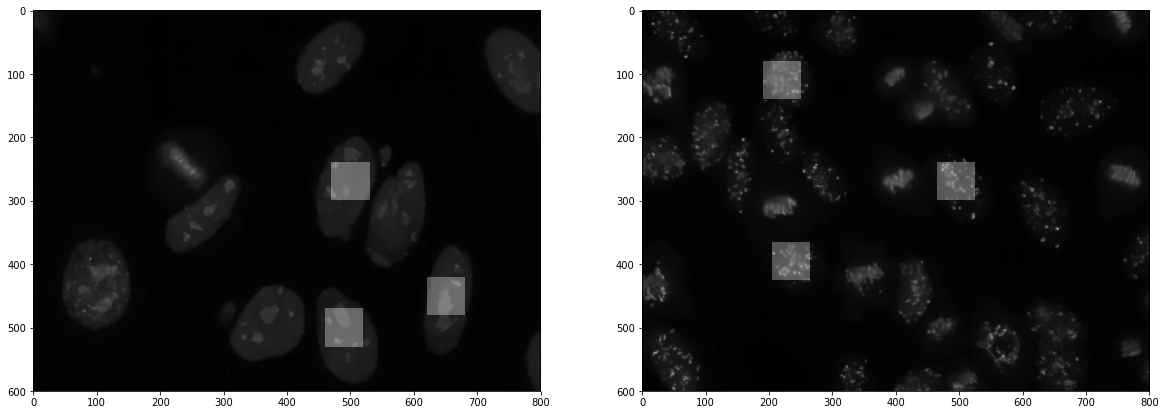

In [42]:
rows, cols = 2, 2
stride = 30
height, width = stride * rows, stride * cols

locs1 = [
    (240, 470),
    (470, 460),
    (420, 620)
]

locs2 = [
    (80, 190),
    (365, 205),
    (240, 465)
]

shade1 = get_shade(norm1, locs1, (height, width))
shade2 = get_shade(norm2, locs2, (height, width))

f, a = plt.subplots(1, 2)
f.set_size_inches(20, 10)

a[0].imshow(norm1, cmap='gray')
a[0].imshow(shade1, cmap='gray', alpha=0.3)

a[1].imshow(norm2, cmap='gray')
a[1].imshow(shade2, cmap='gray', alpha=0.3)

In [43]:
colors = ['red', 'blue']

features1 = texture_features(norm1, locs1, rows, cols, stride)
features2 = texture_features(norm2, locs2, rows, cols, stride)

f_length = features1[0].shape[0]

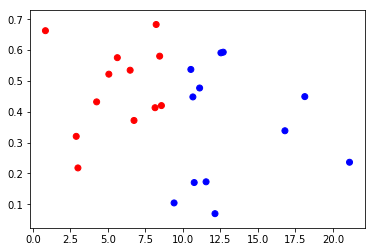

In [44]:
x = np.concatenate([features1[0], features2[0]])
y = np.concatenate([features1[1], features2[1]])

colors_list = [[c] * f_length for c in colors]
colors_list = np.concatenate(colors_list)

plt.scatter(x, y, c=colors_list)